# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
### Load the Data from Pickle File without having to run things from the beginning
import tensorflow as tf
from tensorflow.python.ops.variables import Variable
import cv2
import numpy as np
import scipy.ndimage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import pickle
import os
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
%matplotlib inline

# Reload the data
def load_data(filename):
    pickle_file = filename + '.pickle'
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        train_features = pickle_data['train_dataset']
        train_labels = pickle_data['train_labels']
        valid_features = pickle_data['valid_dataset']
        valid_labels = pickle_data['valid_labels']
        test_features = pickle_data['test_dataset']
        test_labels = pickle_data['test_labels']
        train_dict_features = pickle_data['train_features_accuracy']
        train_dict_labels = pickle_data['train_labels_accuracy']
        del pickle_data  # Free up memory
    print('Data and modules loaded')
    return train_features, train_labels, valid_features, valid_labels, test_features, test_labels, train_dict_features, train_dict_labels

In [2]:
def print_images(data, indices=[]):
    if len(data.shape) <= 3:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        if (data.shape[-1] == 1):
            data = data[:, :, 0]
            ax.imshow(data, cmap='gray')
        else:
            ax.imshow(data)
        if len(indices) > 0:
            print(indices[0])
        plt.show()
    elif len(data.shape) >= 4:
        for d in range(len(data)):
            fig = plt.figure()
            ax = fig.add_subplot(111)
            if (data[d].shape[-1] == 1):
                ax.imshow(data[d, :, :, 0], cmap='gray')
            else:
                ax.imshow(data[d])
            if len(indices) > 0:
                print(indices[d])
            plt.show()
            
def print_class(features, labels, class_no, image_idx):
    if len(labels.shape) > 1:
        if len(labels) == 1:
            indices_by_class = np.where(np.argmax(labels) == class_no)
        else:
            indices_by_class = np.where(np.argmax(labels, axis=1) == class_no)[0]
    else:
        if len(labels) == 1:
            indices_by_class = np.where(labels == class_no)
        else:
            indices_by_class = np.where(labels == class_no)[0]
            
    features_by_class = features[indices_by_class]
    images = features_by_class[image_idx]
    print_images(images, image_idx)
    

In [3]:
def conv_layer(input_layer, filter_size, num_input_channels, num_filters, stride=1, padding='SAME',
               relu=False, pooling=False, pool_size=2, drop=False, keep_prob=0.5, name=None):
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create filter weights with the given shape.
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    # print(weights.get_shape())

    # Create new biases, one for each filter.
    biases = tf.Variable(tf.zeros(num_filters))

    # Create the convolution operation
    conv_layer = tf.nn.conv2d(input=input_layer,
                             filter=weights,
                             strides=[1, stride, stride, 1],
                             padding=padding)

    # Add the biases to the convolution output
    conv_layer = tf.nn.bias_add(conv_layer, biases)
    
    if pooling == 'max':
        # Create max-pooling
        conv_layer = tf.nn.max_pool(value=conv_layer,
                               ksize=[1, pool_size, pool_size, 1],
                               strides=[1, pool_size, pool_size, 1],
                               padding=padding)
    if pooling == 'average':
        # Create average-pooling
        conv_layer = tf.nn.avg_pool(value=conv_layer,
                               ksize=[1, pool_size, pool_size, 1],
                               strides=[1, pool_size, pool_size, 1],
                               padding=padding)
    
    
    if relu:
        # Create the ReLu activation function
        conv_layer = tf.nn.relu(conv_layer)

    if drop:
        # Use Dropout to prevent overfitting
        conv_layer = tf.nn.dropout(conv_layer, keep_prob)
    print(conv_layer.get_shape())
    return conv_layer

# Get the shape of the input layer.
# The shape of the input layer is assumed to be:
# layer_shape == [num_images, img_height, img_width, num_channels]
def flatten_layer(input_layer):
    layer_shape = input_layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()

    # Reshape the layer to [num_images, num_features]
    flat_layer = tf.reshape(input_layer, [-1, num_features])
    print(flat_layer.get_shape())
    return (flat_layer)
    
def fc_layer(input_layer, num_features, fc_size, relu=False, drop=False, keep_prob=0.5):
    ## Create the 1st Fully Connected layer
    # Create new weights and biases.
    shape=[num_features, fc_size]

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    biases = tf.Variable(tf.zeros(fc_size))

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    fc_layer = tf.nn.bias_add(tf.matmul(input_layer, weights), biases)
    
    if relu:
        fc_layer = tf.nn.relu(fc_layer)
    
    if drop:
        fc_layer = tf.nn.dropout(fc_layer, keep_prob)
    print(fc_layer.get_shape())
    return fc_layer

In [4]:
# Load the data from pickle file
filename = 'traffic-signs-rgb'
train_features, train_labels, valid_features, valid_labels, test_features, test_labels, train_dict_features, train_dict_labels = load_data(filename)

Data and modules loaded


43
(32, 32, 3)
(46047, 32, 32, 3) (46047, 43)
(1290, 32, 32, 3) (1290, 43)
(12630, 32, 32, 3) (12630, 43)
(1290, 32, 32, 3) (1290, 43)


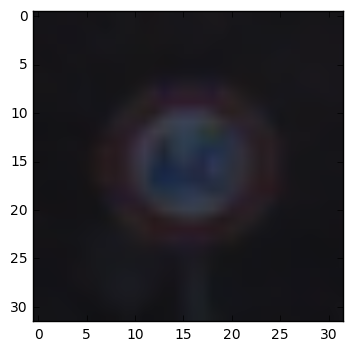

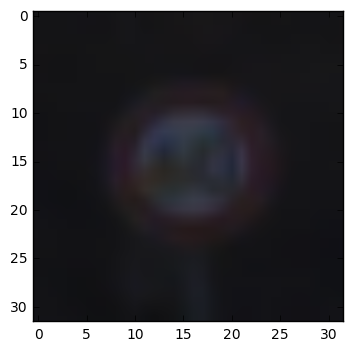

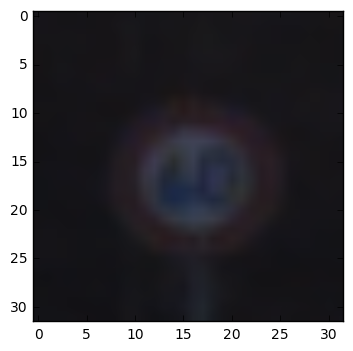

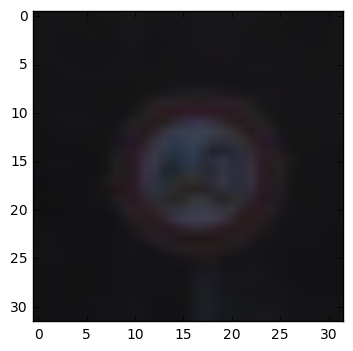

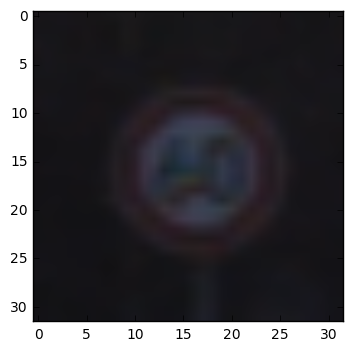

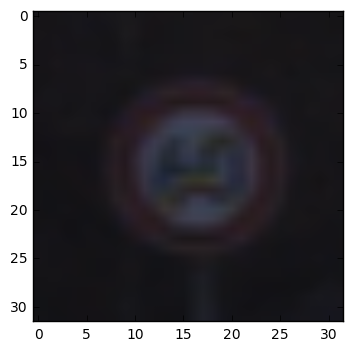

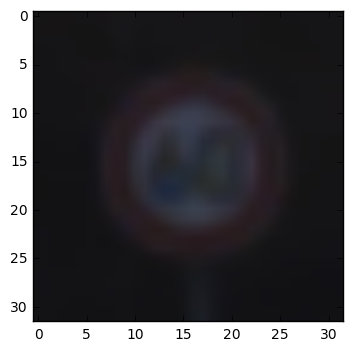

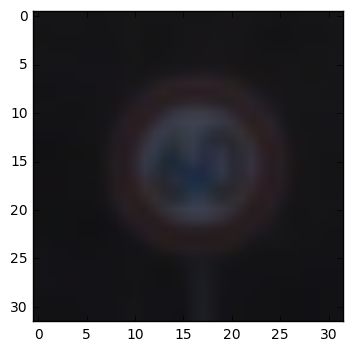

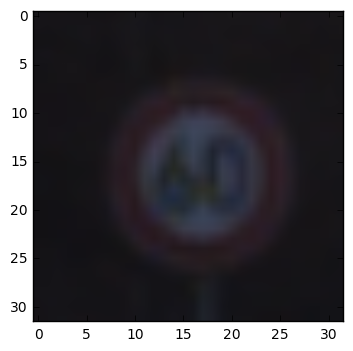

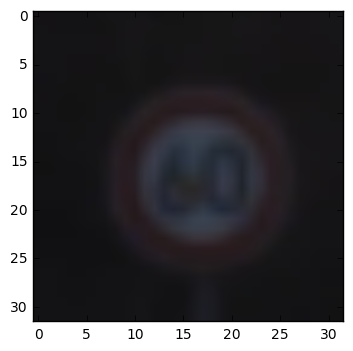

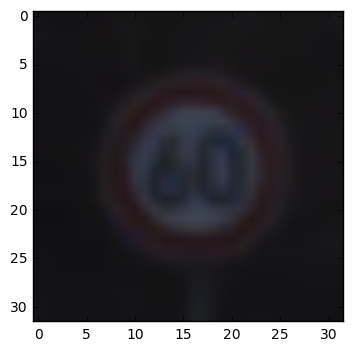

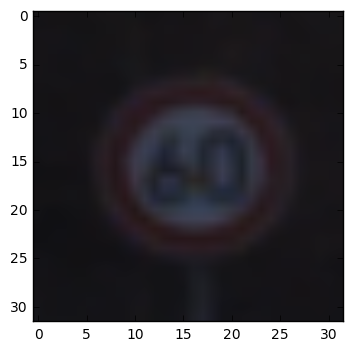

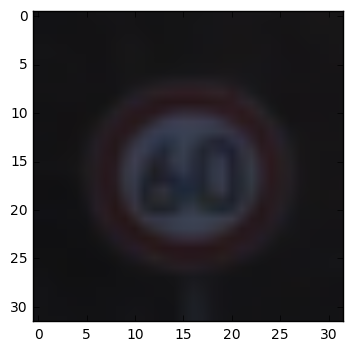

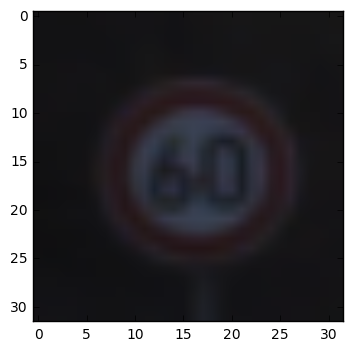

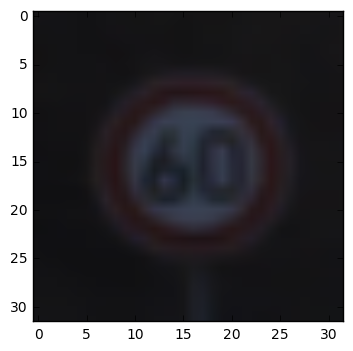

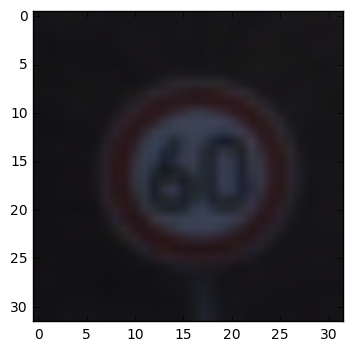

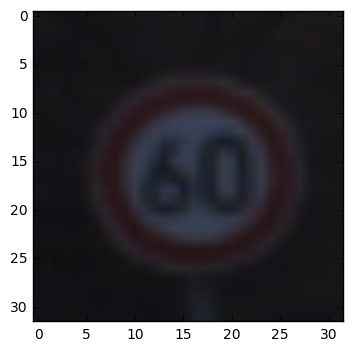

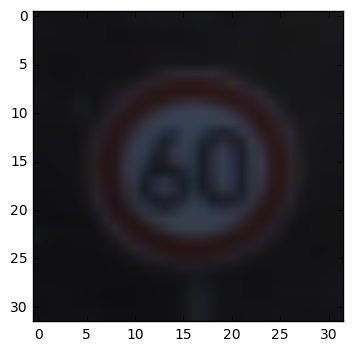

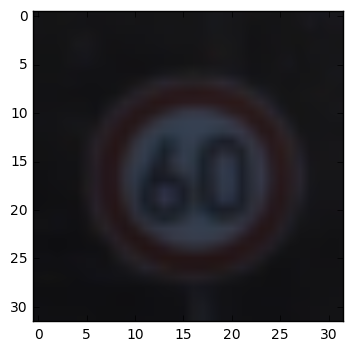

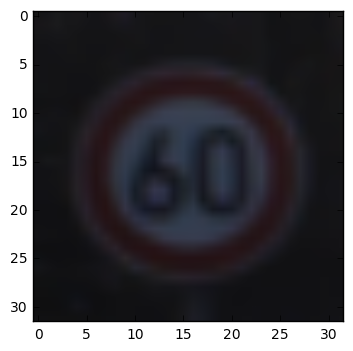

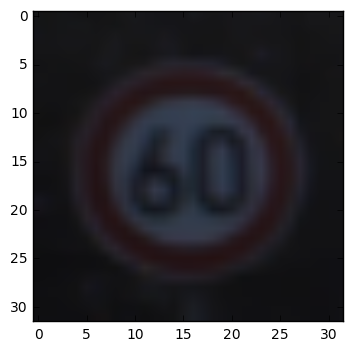

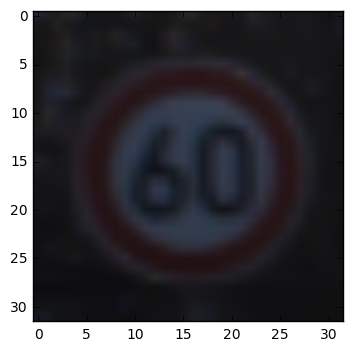

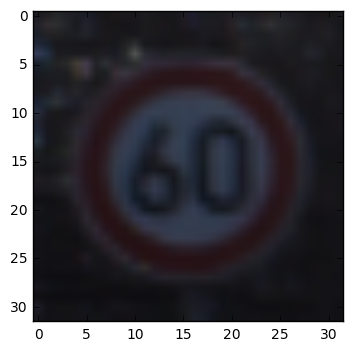

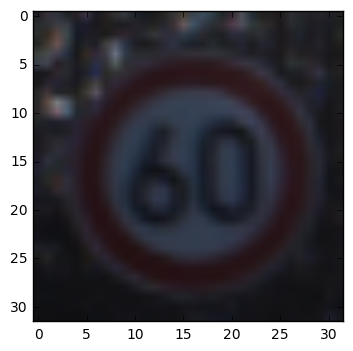

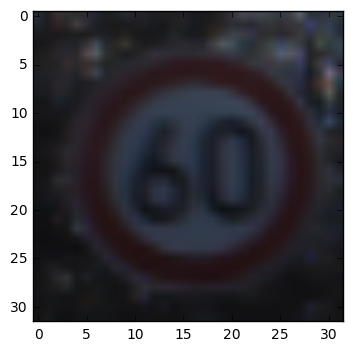

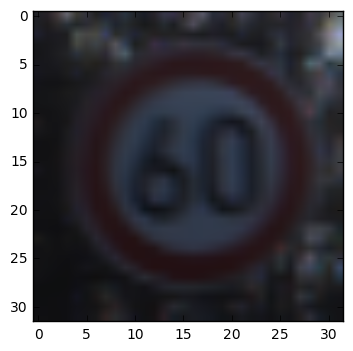

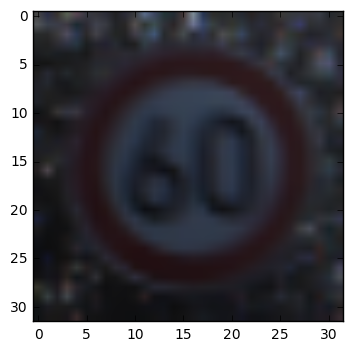

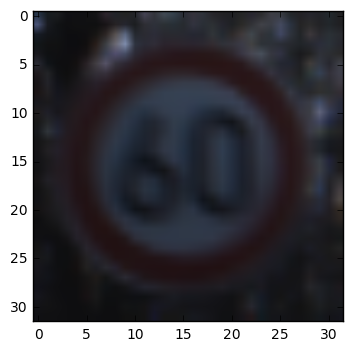

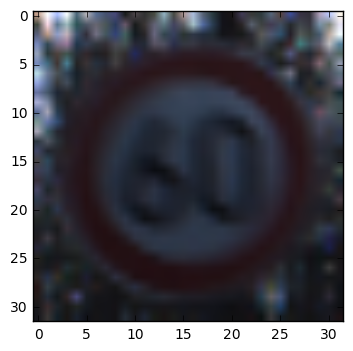

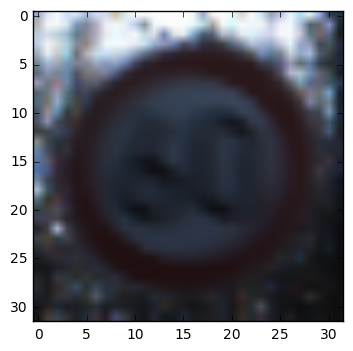

In [5]:
image_shape = train_features[0].shape
n_classes = train_labels.shape[1]

print(n_classes)
print(image_shape)
print(train_features.shape, train_labels.shape)
print(valid_features.shape, valid_labels.shape)
print(test_features.shape, test_labels.shape)
print(train_dict_features.shape, train_dict_labels.shape)

print_images(valid_features[90:120])

In [13]:
### Create an Inception ConvNet
# Create the input data placeholders
features = tf.placeholder(tf.float32, shape=[None, *image_shape])
labels = tf.placeholder(tf.float32, shape=[None, n_classes])
output_size = 16

# 1x1 Conv Layer
print('Conv1 Layer')
conv1_layer = conv_layer(features, 1, image_shape[-1], output_size, stride=2, 
                         padding='VALID', relu=True, drop=True)

# 5x5 Conv Layer, takes in 1x1 Conv Layer Output
print('Conv5 Layer')
conv5_layer = conv_layer(conv1_layer, 5, output_size, output_size, stride=1,
                         padding='SAME', relu=True, drop=True)

print('Conv3 Layer')
# 3x3 Conv Layer, takes in 1x1 Conv Layer Output
conv3_layer = conv_layer(conv1_layer, 3, output_size, output_size, stride=1,
                         padding='SAME', relu=True, drop=True)

print('Pooling Layer')
# Pooling Layer
# pool_layer = conv_layer(features, 5, image_shape[-1], output_size, relu=True, pooling='max')
pool_layer = tf.nn.max_pool(value=features,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='VALID')

print(pool_layer.get_shape())

print('Conv1 After Pooling Layer')
# 1x1 Conv Layer after Pooling
pool_conv1_layer = conv_layer(pool_layer, 1, int(list(pool_layer.get_shape())[-1]), output_size, 
                              stride=1, padding='VALID', relu=True, pooling=False, drop=True)

# Concatenate the outputs
print('Concat Layer')
concat_layer = tf.concat(3, [conv1_layer, conv3_layer, conv5_layer, pool_conv1_layer])
print(concat_layer.get_shape())

print('Flat Layer')
# Flatten the Layer
flat_layer = flatten_layer(concat_layer)

print('Fully Connected Layer 1')
# Fully Connected Layer 1
num_features = int(flat_layer.get_shape()[-1])
fc1_size = int(conv3_layer.get_shape()[-1])*8
fc1_layer = fc_layer(flat_layer, num_features, fc1_size, relu=True, drop=True)

print('Fully Connected Layer 2')
# Fully Connected Layer 2
fc2_size = int(fc1_size/2)
fc2_layer = fc_layer(fc1_layer, fc1_size, fc2_size, relu=True, drop=True)

print('Output Layer')
# Output Layer
output_layer = fc_layer(fc2_layer, fc2_size, n_classes)
# output_layer = fc_layer(fc1_layer, fc1_size, n_classes)


Conv1 Layer
(?, 16, 16, 16)
Conv5 Layer
(?, 16, 16, 16)
Conv3 Layer
(?, 16, 16, 16)
Pooling Layer
(?, 16, 16, 3)
Conv1 After Pooling Layer
(?, 16, 16, 16)
Concat Layer
(?, 16, 16, 64)
Flat Layer
(?, 16384)
Fully Connected Layer 1
(?, 128)
Fully Connected Layer 2
(?, 64)
Output Layer
(?, 43)


In [14]:
## Creating the Softmax predictions, loss, and optimizer functions
prediction = tf.nn.softmax(output_layer)
# cross_entropy = -tf.reduce_sum(labels * tf.log(tf.clip_by_value(prediction,1e-10,1.0)), reduction_indices=[1])
# loss = tf.reduce_mean(cross_entropy)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output_layer, labels))
y_pred_cls = tf.argmax(prediction, 1)

epochs = 100
batch_size = 20
learning_rate = 0.007

# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
# optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Test model
correct_prediction = tf.equal(y_pred_cls, tf.argmax(labels, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
print('Optimization and Accuracy Functions Created')

Optimization and Accuracy Functions Created


In [15]:
# The file path to save the data
# save_file = 'model_yuv.ckpt'
save_file = 'model_rgb_incept.ckpt'
# epochs = 100

# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()

## Run the Session
init = tf.initialize_all_variables()

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Validate model
valid_feed_dict = {features: valid_features, labels: valid_labels}
# Run model on Test data
test_feed_dict = {features: test_features, labels: test_labels}
train_feed_dict = {features: train_dict_features, labels: train_dict_labels}

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
#     saver.restore(sess, save_file)
    batch_count = int(math.ceil(len(train_features)/batch_size))
    
    # Training cycle
    for epoch_i in range(epochs):
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            if batch_start >= len(train_features):
                break
            batch_end = min(batch_start + batch_size, len(train_features))
            batch_features = train_features[batch_start:batch_end]
            batch_labels = train_labels[batch_start:batch_end]
        
            # Run optimizer and get loss
            _, l = sess.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Validation data
        validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)
        # Check accuracy against Training data
        training_accuracy = sess.run(accuracy, feed_dict=train_feed_dict)
        
        # Display logs per epoch step
        print("Epoch:", '%04d' % (epoch_i+1), "loss=", "{:.9f}".format(l)) 
        print("Validation Accuracy=", "{:.9f}".format(validation_accuracy), 
              "Training Accuracy=", "{:.9f}".format(training_accuracy))
        
    print("Optimization Finished!") 
    
    # Save the model
    saver.save(sess, save_file)
    print('Model Saved to ' + save_file)
    
    # Check accuracy against Validation data
    validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)
    print('Validation accuracy at {}'.format(validation_accuracy))
    
    # Check accuracy against Validation data
    test_accuracy = sess.run(accuracy, feed_dict=test_feed_dict)
    print('Test accuracy at {}'.format(test_accuracy))
    
    exam_size = 100
    y_labels = tf.placeholder(tf.float32, shape=[None, n_classes])
    y_true_cls = tf.argmax(y_labels, 1)
    cls_true, cls_pred = sess.run([y_true_cls, y_pred_cls], feed_dict={features: test_features[0:exam_size], 
                                                                   y_labels: test_labels[0:exam_size]})
    print(cls_true)
    print(cls_pred)
    sess.close()


Epoch  1/100:   1%|          | 19/2303 [00:00<01:16, 29.84batches/s]
Exception in thread Thread-140:
Traceback (most recent call last):
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Beili/anaconda/envs/tensorflow/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Epoch  2/100:   0%|          | 3/2303 [00:00<01:18, 29.21batches/s]

Epoch: 0001 loss= 3.778342009
Validation Accuracy= 0.028682170 Training Accuracy= 0.025581395


Epoch  3/100:   0%|          | 3/2303 [00:00<01:20, 28.66batches/s]

Epoch: 0002 loss= 3.681392670
Validation Accuracy= 0.049612403 Training Accuracy= 0.037209302


Epoch  4/100:   0%|          | 3/2303 [00:00<01:19, 28.89batches/s]

Epoch: 0003 loss= 3.569881439
Validation Accuracy= 0.052713178 Training Accuracy= 0.034883723


Epoch  5/100:   0%|          | 3/2303 [00:00<01:20, 28.65batches/s]

Epoch: 0004 loss= 3.454468966
Validation Accuracy= 0.055813953 Training Accuracy= 0.033333335


Epoch  6/100:   0%|          | 3/2303 [00:00<01:21, 28.12batches/s]

Epoch: 0005 loss= 3.406979084
Validation Accuracy= 0.074418604 Training Accuracy= 0.063565895


Epoch  7/100:   0%|          | 3/2303 [00:00<01:21, 28.28batches/s]

Epoch: 0006 loss= 3.341710567
Validation Accuracy= 0.096124031 Training Accuracy= 0.115503877


Epoch  8/100:   0%|          | 3/2303 [00:00<01:22, 27.99batches/s]

Epoch: 0007 loss= 2.956763029
Validation Accuracy= 0.148837209 Training Accuracy= 0.155038759


Epoch  9/100:   0%|          | 3/2303 [00:00<01:21, 28.35batches/s]

Epoch: 0008 loss= 2.679357290
Validation Accuracy= 0.172868222 Training Accuracy= 0.185271323


Epoch 10/100:   0%|          | 3/2303 [00:00<01:25, 26.85batches/s]

Epoch: 0009 loss= 2.445135355
Validation Accuracy= 0.240310073 Training Accuracy= 0.224806204


Epoch 11/100:   0%|          | 3/2303 [00:00<01:21, 28.30batches/s]

Epoch: 0010 loss= 2.149361849
Validation Accuracy= 0.257364333 Training Accuracy= 0.258914739


Epoch 12/100:   0%|          | 3/2303 [00:00<01:21, 28.32batches/s]

Epoch: 0011 loss= 3.005849600
Validation Accuracy= 0.273643404 Training Accuracy= 0.265116274


Epoch 13/100:   0%|          | 3/2303 [00:00<01:20, 28.69batches/s]

Epoch: 0012 loss= 2.306612253
Validation Accuracy= 0.288372099 Training Accuracy= 0.298449606


Epoch 14/100:   0%|          | 3/2303 [00:00<01:19, 28.92batches/s]

Epoch: 0013 loss= 2.578440428
Validation Accuracy= 0.288372099 Training Accuracy= 0.301550388


Epoch 15/100:   0%|          | 3/2303 [00:00<01:18, 29.41batches/s]

Epoch: 0014 loss= 2.305834532
Validation Accuracy= 0.311627895 Training Accuracy= 0.338759691


Epoch 16/100:   0%|          | 3/2303 [00:00<01:17, 29.49batches/s]

Epoch: 0015 loss= 1.787203908
Validation Accuracy= 0.338759691 Training Accuracy= 0.343410850


Epoch 17/100:   0%|          | 3/2303 [00:00<01:21, 28.22batches/s]

Epoch: 0016 loss= 1.897421479
Validation Accuracy= 0.338759691 Training Accuracy= 0.344961226


Epoch 18/100:   0%|          | 3/2303 [00:00<01:18, 29.36batches/s]

Epoch: 0017 loss= 1.198390245
Validation Accuracy= 0.370542645 Training Accuracy= 0.366666675


Epoch 19/100:   0%|          | 3/2303 [00:00<01:19, 28.98batches/s]

Epoch: 0018 loss= 1.584476590
Validation Accuracy= 0.344961226 Training Accuracy= 0.388372093


Epoch 20/100:   0%|          | 3/2303 [00:00<01:19, 28.75batches/s]

Epoch: 0019 loss= 1.764851451
Validation Accuracy= 0.372868210 Training Accuracy= 0.397674412


Epoch 21/100:   0%|          | 3/2303 [00:00<01:19, 28.98batches/s]

Epoch: 0020 loss= 1.785853267
Validation Accuracy= 0.384496123 Training Accuracy= 0.398449600


Epoch 22/100:   0%|          | 3/2303 [00:00<01:17, 29.68batches/s]

Epoch: 0021 loss= 1.933810353
Validation Accuracy= 0.410077512 Training Accuracy= 0.434883714


Epoch 23/100:   0%|          | 4/2303 [00:00<01:14, 30.73batches/s]

Epoch: 0022 loss= 2.071494818
Validation Accuracy= 0.413178295 Training Accuracy= 0.441860467


Epoch 24/100:   0%|          | 4/2303 [00:00<01:15, 30.53batches/s]

Epoch: 0023 loss= 1.537456870
Validation Accuracy= 0.415503889 Training Accuracy= 0.446511626


Epoch 25/100:   0%|          | 3/2303 [00:00<01:20, 28.47batches/s]

Epoch: 0024 loss= 1.319357514
Validation Accuracy= 0.428682178 Training Accuracy= 0.448837221


Epoch 26/100:   0%|          | 4/2303 [00:00<01:14, 30.87batches/s]

Epoch: 0025 loss= 1.231135607
Validation Accuracy= 0.428682178 Training Accuracy= 0.486046523


Epoch 27/100:   0%|          | 3/2303 [00:00<01:29, 25.80batches/s]

Epoch: 0026 loss= 1.667983294
Validation Accuracy= 0.441085279 Training Accuracy= 0.499224812


Epoch 28/100:   0%|          | 3/2303 [00:00<01:19, 28.80batches/s]

Epoch: 0027 loss= 0.974227607
Validation Accuracy= 0.477519393 Training Accuracy= 0.510852695


Epoch 29/100:   0%|          | 3/2303 [00:00<01:19, 28.86batches/s]

Epoch: 0028 loss= 1.050534248
Validation Accuracy= 0.455813944 Training Accuracy= 0.492248058


Epoch 30/100:   0%|          | 3/2303 [00:00<01:20, 28.62batches/s]

Epoch: 0029 loss= 1.062005639
Validation Accuracy= 0.475193799 Training Accuracy= 0.520930231


Epoch 31/100:   0%|          | 3/2303 [00:00<01:22, 28.04batches/s]

Epoch: 0030 loss= 1.510783076
Validation Accuracy= 0.466666669 Training Accuracy= 0.520155013


Epoch 32/100:   0%|          | 3/2303 [00:00<01:17, 29.60batches/s]

Epoch: 0031 loss= 1.596225142
Validation Accuracy= 0.502325594 Training Accuracy= 0.544186056


Epoch 33/100:   0%|          | 3/2303 [00:00<01:19, 29.10batches/s]

Epoch: 0032 loss= 1.433394194
Validation Accuracy= 0.520930231 Training Accuracy= 0.517829478


Epoch 34/100:   0%|          | 3/2303 [00:00<01:18, 29.30batches/s]

Epoch: 0033 loss= 1.086549759
Validation Accuracy= 0.521705449 Training Accuracy= 0.533333361


Epoch 35/100:   0%|          | 3/2303 [00:00<01:22, 27.93batches/s]

Epoch: 0034 loss= 1.254595876
Validation Accuracy= 0.522480607 Training Accuracy= 0.532558143


Epoch 36/100:   0%|          | 3/2303 [00:00<01:18, 29.39batches/s]

Epoch: 0035 loss= 1.460453987
Validation Accuracy= 0.519379854 Training Accuracy= 0.534883738


Epoch 37/100:   0%|          | 3/2303 [00:00<01:20, 28.65batches/s]

Epoch: 0036 loss= 1.296531081
Validation Accuracy= 0.523255825 Training Accuracy= 0.557364345


Epoch 38/100:   0%|          | 3/2303 [00:00<01:19, 29.01batches/s]

Epoch: 0037 loss= 1.179433942
Validation Accuracy= 0.532558143 Training Accuracy= 0.540310085


Epoch 39/100:   0%|          | 3/2303 [00:00<01:19, 28.98batches/s]

Epoch: 0038 loss= 1.010065198
Validation Accuracy= 0.558914721 Training Accuracy= 0.561240315


Epoch 40/100:   0%|          | 3/2303 [00:00<01:19, 29.03batches/s]

Epoch: 0039 loss= 1.058074832
Validation Accuracy= 0.520930231 Training Accuracy= 0.575968981


Epoch 41/100:   0%|          | 3/2303 [00:00<01:19, 28.91batches/s]

Epoch: 0040 loss= 0.953138173
Validation Accuracy= 0.556589127 Training Accuracy= 0.578294575


Epoch 42/100:   0%|          | 3/2303 [00:00<01:18, 29.22batches/s]

Epoch: 0041 loss= 0.890089154
Validation Accuracy= 0.568217039 Training Accuracy= 0.579844952


Epoch 43/100:   0%|          | 3/2303 [00:00<01:17, 29.83batches/s]

Epoch: 0042 loss= 0.894630075
Validation Accuracy= 0.571317852 Training Accuracy= 0.575968981


Epoch 44/100:   0%|          | 3/2303 [00:00<01:17, 29.65batches/s]

Epoch: 0043 loss= 0.855394244
Validation Accuracy= 0.551162779 Training Accuracy= 0.620930254


Epoch 45/100:   0%|          | 3/2303 [00:00<01:19, 28.76batches/s]

Epoch: 0044 loss= 0.880687296
Validation Accuracy= 0.567441881 Training Accuracy= 0.609302342


Epoch 46/100:   0%|          | 3/2303 [00:00<01:17, 29.85batches/s]

Epoch: 0045 loss= 1.216679692
Validation Accuracy= 0.582170546 Training Accuracy= 0.622480631


Epoch 47/100:   0%|          | 3/2303 [00:00<01:17, 29.62batches/s]

Epoch: 0046 loss= 1.069934964
Validation Accuracy= 0.581395328 Training Accuracy= 0.611627936


Epoch 48/100:   0%|          | 3/2303 [00:00<01:18, 29.20batches/s]

Epoch: 0047 loss= 0.883293509
Validation Accuracy= 0.577519357 Training Accuracy= 0.641085267


Epoch 49/100:   0%|          | 4/2303 [00:00<01:14, 30.80batches/s]

Epoch: 0048 loss= 0.758181393
Validation Accuracy= 0.580620170 Training Accuracy= 0.636434138


Epoch 50/100:   0%|          | 3/2303 [00:00<01:19, 29.10batches/s]

Epoch: 0049 loss= 1.052425504
Validation Accuracy= 0.612403095 Training Accuracy= 0.650387585


Epoch 51/100:   0%|          | 3/2303 [00:00<01:18, 29.38batches/s]

Epoch: 0050 loss= 1.110262036
Validation Accuracy= 0.600000024 Training Accuracy= 0.640310049


Epoch 52/100:   0%|          | 3/2303 [00:00<01:20, 28.70batches/s]

Epoch: 0051 loss= 0.784949720
Validation Accuracy= 0.580620170 Training Accuracy= 0.636434138


Epoch 53/100:   0%|          | 3/2303 [00:00<01:17, 29.79batches/s]

Epoch: 0052 loss= 1.564568639
Validation Accuracy= 0.602325559 Training Accuracy= 0.635658920


Epoch 54/100:   0%|          | 3/2303 [00:00<01:17, 29.73batches/s]

Epoch: 0053 loss= 0.875569463
Validation Accuracy= 0.617054284 Training Accuracy= 0.642635643


Epoch 55/100:   0%|          | 3/2303 [00:00<01:18, 29.21batches/s]

Epoch: 0054 loss= 0.793239951
Validation Accuracy= 0.616279066 Training Accuracy= 0.637209296


Epoch 56/100:   0%|          | 3/2303 [00:00<01:18, 29.18batches/s]

Epoch: 0055 loss= 0.518256605
Validation Accuracy= 0.617054284 Training Accuracy= 0.664341092


Epoch 57/100:   0%|          | 3/2303 [00:00<01:17, 29.63batches/s]

Epoch: 0056 loss= 0.900412261
Validation Accuracy= 0.616279066 Training Accuracy= 0.644186020


Epoch 58/100:   0%|          | 3/2303 [00:00<01:18, 29.14batches/s]

Epoch: 0057 loss= 1.235807300
Validation Accuracy= 0.614728689 Training Accuracy= 0.668217063


Epoch 59/100:   0%|          | 3/2303 [00:00<01:19, 29.04batches/s]

Epoch: 0058 loss= 0.649321258
Validation Accuracy= 0.637209296 Training Accuracy= 0.651937962


Epoch 60/100:   0%|          | 3/2303 [00:00<01:17, 29.53batches/s]

Epoch: 0059 loss= 0.995541036
Validation Accuracy= 0.626356602 Training Accuracy= 0.646511614


Epoch 61/100:   0%|          | 3/2303 [00:00<01:18, 29.34batches/s]

Epoch: 0060 loss= 0.585970044
Validation Accuracy= 0.611627936 Training Accuracy= 0.674418628


Epoch 62/100:   0%|          | 3/2303 [00:00<01:19, 28.96batches/s]

Epoch: 0061 loss= 0.782491267
Validation Accuracy= 0.634883702 Training Accuracy= 0.681395352


Epoch 63/100:   0%|          | 3/2303 [00:00<01:17, 29.52batches/s]

Epoch: 0062 loss= 0.858613670
Validation Accuracy= 0.619379818 Training Accuracy= 0.657364368


Epoch 64/100:   0%|          | 3/2303 [00:00<01:17, 29.81batches/s]

Epoch: 0063 loss= 1.011677623
Validation Accuracy= 0.634108543 Training Accuracy= 0.674418628


Epoch 65/100:   0%|          | 3/2303 [00:00<01:17, 29.73batches/s]

Epoch: 0064 loss= 1.075791121
Validation Accuracy= 0.634883702 Training Accuracy= 0.686046541


Epoch 66/100:   0%|          | 3/2303 [00:00<01:20, 28.64batches/s]

Epoch: 0065 loss= 0.198906064
Validation Accuracy= 0.656589150 Training Accuracy= 0.699224830


Epoch 67/100:   0%|          | 3/2303 [00:00<01:17, 29.72batches/s]

Epoch: 0066 loss= 0.601025462
Validation Accuracy= 0.656589150 Training Accuracy= 0.693798423


Epoch 68/100:   0%|          | 3/2303 [00:00<01:17, 29.85batches/s]

Epoch: 0067 loss= 0.814434111
Validation Accuracy= 0.658139527 Training Accuracy= 0.689922452


Epoch 69/100:   0%|          | 3/2303 [00:00<01:18, 29.39batches/s]

Epoch: 0068 loss= 0.713621199
Validation Accuracy= 0.669767439 Training Accuracy= 0.680620134


Epoch 70/100:   0%|          | 3/2303 [00:00<01:18, 29.44batches/s]

Epoch: 0069 loss= 0.662356377
Validation Accuracy= 0.662015498 Training Accuracy= 0.679844975


Epoch 71/100:   0%|          | 3/2303 [00:00<01:19, 29.07batches/s]

Epoch: 0070 loss= 0.593974590
Validation Accuracy= 0.675193787 Training Accuracy= 0.701550364


Epoch 72/100:   0%|          | 4/2303 [00:00<01:14, 30.72batches/s]

Epoch: 0071 loss= 0.364779413
Validation Accuracy= 0.671317816 Training Accuracy= 0.703100801


Epoch 73/100:   0%|          | 4/2303 [00:00<01:14, 30.96batches/s]

Epoch: 0072 loss= 1.071840167
Validation Accuracy= 0.688372076 Training Accuracy= 0.689922452


Epoch 74/100:   0%|          | 3/2303 [00:00<01:17, 29.77batches/s]

Epoch: 0073 loss= 0.577312768
Validation Accuracy= 0.675969005 Training Accuracy= 0.712403119


Epoch 75/100:   0%|          | 3/2303 [00:00<01:18, 29.40batches/s]

Epoch: 0074 loss= 0.879313409
Validation Accuracy= 0.675969005 Training Accuracy= 0.716279089


Epoch 76/100:   0%|          | 3/2303 [00:00<01:18, 29.29batches/s]

Epoch: 0075 loss= 0.899492681
Validation Accuracy= 0.668217063 Training Accuracy= 0.698449612


Epoch 77/100:   0%|          | 3/2303 [00:00<01:18, 29.45batches/s]

Epoch: 0076 loss= 1.136553645
Validation Accuracy= 0.668217063 Training Accuracy= 0.724031031


Epoch 78/100:   0%|          | 3/2303 [00:00<01:17, 29.78batches/s]

Epoch: 0077 loss= 0.905186951
Validation Accuracy= 0.681395352 Training Accuracy= 0.707751930


Epoch 79/100:   0%|          | 3/2303 [00:00<01:19, 28.88batches/s]

Epoch: 0078 loss= 0.536058307
Validation Accuracy= 0.693798423 Training Accuracy= 0.713178277


Epoch 80/100:   0%|          | 3/2303 [00:00<01:17, 29.86batches/s]

Epoch: 0079 loss= 0.743312001
Validation Accuracy= 0.686821699 Training Accuracy= 0.729457378


Epoch 81/100:   0%|          | 3/2303 [00:00<01:18, 29.41batches/s]

Epoch: 0080 loss= 0.801756024
Validation Accuracy= 0.679844975 Training Accuracy= 0.718604624


Epoch 82/100:   0%|          | 4/2303 [00:00<01:15, 30.46batches/s]

Epoch: 0081 loss= 0.942258358
Validation Accuracy= 0.679844975 Training Accuracy= 0.724031031


Epoch 83/100:   0%|          | 4/2303 [00:00<01:14, 30.74batches/s]

Epoch: 0082 loss= 0.504162252
Validation Accuracy= 0.675193787 Training Accuracy= 0.730232537


Epoch 84/100:   0%|          | 4/2303 [00:00<01:15, 30.30batches/s]

Epoch: 0083 loss= 0.710513532
Validation Accuracy= 0.687596917 Training Accuracy= 0.735658944


Epoch 85/100:   0%|          | 4/2303 [00:00<01:14, 30.69batches/s]

Epoch: 0084 loss= 0.608428419
Validation Accuracy= 0.689922452 Training Accuracy= 0.730232537


Epoch 86/100:   0%|          | 3/2303 [00:00<01:17, 29.63batches/s]

Epoch: 0085 loss= 0.627013981
Validation Accuracy= 0.696899235 Training Accuracy= 0.733333349


Epoch 87/100:   0%|          | 3/2303 [00:00<01:17, 29.50batches/s]

Epoch: 0086 loss= 1.074805379
Validation Accuracy= 0.693023264 Training Accuracy= 0.741860449


Epoch 88/100:   0%|          | 3/2303 [00:00<01:17, 29.75batches/s]

Epoch: 0087 loss= 1.071854711
Validation Accuracy= 0.703100801 Training Accuracy= 0.742635667


Epoch 89/100:   0%|          | 3/2303 [00:00<01:18, 29.31batches/s]

Epoch: 0088 loss= 0.877456963
Validation Accuracy= 0.711627901 Training Accuracy= 0.737984478


Epoch 90/100:   0%|          | 3/2303 [00:00<01:16, 29.97batches/s]

Epoch: 0089 loss= 0.516117692
Validation Accuracy= 0.702325583 Training Accuracy= 0.743410826


Epoch 91/100:   0%|          | 4/2303 [00:00<01:14, 30.69batches/s]

Epoch: 0090 loss= 0.885764122
Validation Accuracy= 0.716279089 Training Accuracy= 0.762790680


Epoch 92/100:   0%|          | 3/2303 [00:00<01:17, 29.73batches/s]

Epoch: 0091 loss= 0.347695589
Validation Accuracy= 0.699224830 Training Accuracy= 0.736434102


Epoch 93/100:   0%|          | 3/2303 [00:00<01:19, 28.94batches/s]

Epoch: 0092 loss= 0.671746373
Validation Accuracy= 0.691472888 Training Accuracy= 0.752713203


Epoch 94/100:   0%|          | 3/2303 [00:00<01:19, 29.06batches/s]

Epoch: 0093 loss= 1.026701689
Validation Accuracy= 0.718604624 Training Accuracy= 0.754263580


Epoch 95/100:   0%|          | 3/2303 [00:00<01:19, 28.97batches/s]

Epoch: 0094 loss= 0.749254525
Validation Accuracy= 0.717829466 Training Accuracy= 0.747286797


Epoch 96/100:   0%|          | 3/2303 [00:00<01:16, 29.93batches/s]

Epoch: 0095 loss= 0.301729172
Validation Accuracy= 0.706201553 Training Accuracy= 0.777519405


Epoch 97/100:   0%|          | 4/2303 [00:00<01:14, 30.69batches/s]

Epoch: 0096 loss= 0.389592320
Validation Accuracy= 0.721705437 Training Accuracy= 0.759689927


Epoch 98/100:   0%|          | 3/2303 [00:00<01:20, 28.41batches/s]

Epoch: 0097 loss= 0.340595961
Validation Accuracy= 0.708527148 Training Accuracy= 0.757364333


Epoch 99/100:   0%|          | 4/2303 [00:00<01:14, 30.69batches/s]

Epoch: 0098 loss= 1.644033551
Validation Accuracy= 0.724806190 Training Accuracy= 0.771317840


Epoch 100/100:   0%|          | 3/2303 [00:00<01:18, 29.31batches/s]

Epoch: 0099 loss= 0.337035835
Validation Accuracy= 0.732558131 Training Accuracy= 0.742635667


Epoch 100/100: 100%|██████████| 2303/2303 [01:12<00:00, 32.37batches/s]


Epoch: 0100 loss= 0.538941681
Validation Accuracy= 0.713178277 Training Accuracy= 0.751937985
Optimization Finished!
Model Saved to model_rgb_incept.ckpt
Validation accuracy at 0.7069767713546753
Test accuracy at 0.5105304718017578
[16  1 38 33 11 38 18 12 25 35 12  7 23  7  4  9 21 20 27 38  4 33  9  3  1
 11 13 10  9 11  5 17 34 23  2 17  3 12 16  8  7 30 18 12 24 25  3 10 18  8
 25 13 15  9 13 35  5 26  9 16 38 10  4  9 15  9 26  2  5 28 11 25 30 34  5
 12  1 10 25 25 21 33 25  7 10 35  3  7 22 13  3  1  2 14 12 32  3 38  9 33]
[16  1 38 33 11 38 18 42 29 35 11  7 20  5  1  9 31 29 27 34  7 33  9 42  1
 11 13 10  2 11  8 17 34 20  4 14  1 12 16  8  8 30 31 12 28 24  1 10 18  3
  4 13  1  2 13 41  5 26  9 16 38 10  4 10  1  9 26  5  8 22 29 20 18 34  5
 12  2 10 21 25 21 37 22 15 10 35  3  5 22 13 16  1  0 14 12 32  3 36 10 34]


In [16]:
# The file path to save the data
# save_file = 'model_yuv.ckpt'
save_file = 'model_rgb_incept.ckpt'
epoch_count = 200 # Keeps track of how many epochs I've run on this model so far

# Class used to save and/or restore Tensor Variables
saver = tf.train.Saver()

# Validate model
valid_feed_dict = {features: valid_features, labels: valid_labels}
# Run model on Test data
test_feed_dict = {features: test_features, labels: test_labels}
train_feed_dict = {features: train_dict_features, labels: train_dict_labels}

# Launch the graph
with tf.Session() as sess:
    saver.restore(sess, save_file)
    batch_count = int(math.ceil(len(train_features)/batch_size))
    
    # Training cycle
    for epoch_i in range(epochs):
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            if batch_start >= len(train_features):
                break
            batch_end = min(batch_start + batch_size, len(train_features))
            batch_features = train_features[batch_start:batch_end]
            batch_labels = train_labels[batch_start:batch_end]
        
            # Run optimizer and get loss
            _, l = sess.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Validation data
        validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)
        # Check accuracy against Training data
        training_accuracy = sess.run(accuracy, feed_dict=train_feed_dict)
        
        # Display logs per epoch step
        print("Epoch:", '%04d' % (epoch_i+1), "loss=", "{:.9f}".format(l)) 
        print("Validation Accuracy=", "{:.9f}".format(validation_accuracy), 
              "Training Accuracy=", "{:.9f}".format(training_accuracy))
        
    print("Optimization Finished!") 
    
    # Save the model
    saver.save(sess, save_file)
    print('Model Saved to ' + save_file)
    
    # Check accuracy against Validation data
    validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)
    print('Validation accuracy at {}'.format(validation_accuracy))
    
    # Check accuracy against Validation data
    test_accuracy = sess.run(accuracy, feed_dict=test_feed_dict)
    print('Test accuracy at {}'.format(test_accuracy))
    
    exam_size = 100
    y_labels = tf.placeholder(tf.float32, shape=[None, n_classes])
    y_true_cls = tf.argmax(y_labels, 1)
    cls_true, cls_pred = sess.run([y_true_cls, y_pred_cls], feed_dict={features: test_features[0:exam_size], 
                                                                   y_labels: test_labels[0:exam_size]})
    print(cls_true)
    print(cls_pred)
    sess.close()

Epoch  2/100:   0%|          | 3/2303 [00:00<01:19, 28.93batches/s]

Epoch: 0001 loss= 0.200576782
Validation Accuracy= 0.721705437 Training Accuracy= 0.765116274


Epoch  3/100:   0%|          | 3/2303 [00:00<01:17, 29.64batches/s]

Epoch: 0002 loss= 0.278932124
Validation Accuracy= 0.717054248 Training Accuracy= 0.768217027


Epoch  4/100:   0%|          | 3/2303 [00:00<01:16, 29.97batches/s]

Epoch: 0003 loss= 0.679728568
Validation Accuracy= 0.733333349 Training Accuracy= 0.782170534


Epoch  5/100:   0%|          | 3/2303 [00:00<01:18, 29.14batches/s]

Epoch: 0004 loss= 1.552112222
Validation Accuracy= 0.743410826 Training Accuracy= 0.787596881


Epoch  6/100:   0%|          | 3/2303 [00:00<01:16, 29.91batches/s]

Epoch: 0005 loss= 0.503676772
Validation Accuracy= 0.737209320 Training Accuracy= 0.777519405


Epoch  7/100:   0%|          | 3/2303 [00:00<01:18, 29.36batches/s]

Epoch: 0006 loss= 0.802245021
Validation Accuracy= 0.739534855 Training Accuracy= 0.768217027


Epoch  8/100:   0%|          | 3/2303 [00:00<01:18, 29.48batches/s]

Epoch: 0007 loss= 0.492467582
Validation Accuracy= 0.738759696 Training Accuracy= 0.766666651


Epoch  9/100:   0%|          | 3/2303 [00:00<01:17, 29.58batches/s]

Epoch: 0008 loss= 0.620020688
Validation Accuracy= 0.726356566 Training Accuracy= 0.755813956


Epoch 10/100:   0%|          | 3/2303 [00:00<01:17, 29.87batches/s]

Epoch: 0009 loss= 0.201937512
Validation Accuracy= 0.727907002 Training Accuracy= 0.786046505


Epoch 11/100:   0%|          | 3/2303 [00:00<01:21, 28.06batches/s]

Epoch: 0010 loss= 0.830508649
Validation Accuracy= 0.734108508 Training Accuracy= 0.767441869


Epoch 12/100:   0%|          | 3/2303 [00:00<01:20, 28.53batches/s]

Epoch: 0011 loss= 0.216257542
Validation Accuracy= 0.758914709 Training Accuracy= 0.791472852


Epoch 13/100:   0%|          | 3/2303 [00:00<01:20, 28.62batches/s]

Epoch: 0012 loss= 0.538390219
Validation Accuracy= 0.744186044 Training Accuracy= 0.800775170


Epoch 14/100:   0%|          | 3/2303 [00:00<01:17, 29.59batches/s]

Epoch: 0013 loss= 0.247842565
Validation Accuracy= 0.759689927 Training Accuracy= 0.793023229


Epoch 15/100:   0%|          | 3/2303 [00:00<01:20, 28.67batches/s]

Epoch: 0014 loss= 0.645067155
Validation Accuracy= 0.754263580 Training Accuracy= 0.797674417


Epoch 16/100:   0%|          | 3/2303 [00:00<01:18, 29.15batches/s]

Epoch: 0015 loss= 0.551609099
Validation Accuracy= 0.755813956 Training Accuracy= 0.791472852


Epoch 17/100:   0%|          | 3/2303 [00:00<01:20, 28.59batches/s]

Epoch: 0016 loss= 0.324136943
Validation Accuracy= 0.757364333 Training Accuracy= 0.782170534


Epoch 18/100:   0%|          | 3/2303 [00:00<01:17, 29.52batches/s]

Epoch: 0017 loss= 0.199518815
Validation Accuracy= 0.749612391 Training Accuracy= 0.792248070


Epoch 19/100:   0%|          | 4/2303 [00:00<01:14, 30.81batches/s]

Epoch: 0018 loss= 0.626808345
Validation Accuracy= 0.752713203 Training Accuracy= 0.798449636


Epoch 20/100:   0%|          | 3/2303 [00:00<01:22, 27.77batches/s]

Epoch: 0019 loss= 0.358365297
Validation Accuracy= 0.760465145 Training Accuracy= 0.786046505


Epoch 21/100:   0%|          | 3/2303 [00:00<01:20, 28.61batches/s]

Epoch: 0020 loss= 0.118920162
Validation Accuracy= 0.746511638 Training Accuracy= 0.799224794


Epoch 22/100:   0%|          | 3/2303 [00:00<01:18, 29.12batches/s]

Epoch: 0021 loss= 0.928090274
Validation Accuracy= 0.738759696 Training Accuracy= 0.796899199


Epoch 23/100:   0%|          | 3/2303 [00:00<01:17, 29.85batches/s]

Epoch: 0022 loss= 0.709901690
Validation Accuracy= 0.742635667 Training Accuracy= 0.797674417


Epoch 24/100:   0%|          | 3/2303 [00:00<01:18, 29.29batches/s]

Epoch: 0023 loss= 1.524323106
Validation Accuracy= 0.749612391 Training Accuracy= 0.790697694


Epoch 25/100:   0%|          | 3/2303 [00:00<01:18, 29.45batches/s]

Epoch: 0024 loss= 2.073484182
Validation Accuracy= 0.760465145 Training Accuracy= 0.798449636


Epoch 26/100:   0%|          | 3/2303 [00:00<01:17, 29.85batches/s]

Epoch: 0025 loss= 0.151409388
Validation Accuracy= 0.768992245 Training Accuracy= 0.781395376


Epoch 27/100:   0%|          | 3/2303 [00:00<01:21, 28.37batches/s]

Epoch: 0026 loss= 0.405255556
Validation Accuracy= 0.757364333 Training Accuracy= 0.809302330


Epoch 28/100:   0%|          | 3/2303 [00:00<01:20, 28.56batches/s]

Epoch: 0027 loss= 0.562323272
Validation Accuracy= 0.765891492 Training Accuracy= 0.807751954


Epoch 29/100:   0%|          | 3/2303 [00:00<01:17, 29.57batches/s]

Epoch: 0028 loss= 0.520032465
Validation Accuracy= 0.777519405 Training Accuracy= 0.814728677


Epoch 30/100:   0%|          | 3/2303 [00:00<01:18, 29.21batches/s]

Epoch: 0029 loss= 0.764111936
Validation Accuracy= 0.765116274 Training Accuracy= 0.796124041


Epoch 31/100:   0%|          | 3/2303 [00:00<01:26, 26.70batches/s]

Epoch: 0030 loss= 0.241621122
Validation Accuracy= 0.770542622 Training Accuracy= 0.828682184


Epoch 32/100:   0%|          | 4/2303 [00:00<01:14, 31.05batches/s]

Epoch: 0031 loss= 0.746326566
Validation Accuracy= 0.746511638 Training Accuracy= 0.812403083


Epoch 33/100:   0%|          | 3/2303 [00:00<01:17, 29.56batches/s]

Epoch: 0032 loss= 0.423617333
Validation Accuracy= 0.775968969 Training Accuracy= 0.802325606


Epoch 34/100:   0%|          | 4/2303 [00:00<01:14, 30.77batches/s]

Epoch: 0033 loss= 0.112447381
Validation Accuracy= 0.793798447 Training Accuracy= 0.826356590


Epoch 35/100:   0%|          | 3/2303 [00:00<01:18, 29.39batches/s]

Epoch: 0034 loss= 0.633388638
Validation Accuracy= 0.770542622 Training Accuracy= 0.826356590


Epoch 36/100:   0%|          | 3/2303 [00:00<01:20, 28.54batches/s]

Epoch: 0035 loss= 0.603934824
Validation Accuracy= 0.793798447 Training Accuracy= 0.808527112


Epoch 37/100:   0%|          | 3/2303 [00:00<01:19, 28.96batches/s]

Epoch: 0036 loss= 0.829430461
Validation Accuracy= 0.763565898 Training Accuracy= 0.795348823


Epoch 38/100:   0%|          | 4/2303 [00:00<01:14, 30.68batches/s]

Epoch: 0037 loss= 1.427054524
Validation Accuracy= 0.784496129 Training Accuracy= 0.831782937


Epoch 39/100:   0%|          | 3/2303 [00:00<01:20, 28.42batches/s]

Epoch: 0038 loss= 0.701599598
Validation Accuracy= 0.757364333 Training Accuracy= 0.827131808


Epoch 40/100:   0%|          | 3/2303 [00:00<01:19, 28.76batches/s]

Epoch: 0039 loss= 0.657530129
Validation Accuracy= 0.789147258 Training Accuracy= 0.817054272


Epoch 41/100:   0%|          | 3/2303 [00:00<01:17, 29.84batches/s]

Epoch: 0040 loss= 1.516407371
Validation Accuracy= 0.776744187 Training Accuracy= 0.800000012


Epoch 42/100:   0%|          | 3/2303 [00:00<01:18, 29.30batches/s]

Epoch: 0041 loss= 0.572655380
Validation Accuracy= 0.772092998 Training Accuracy= 0.810852706


Epoch 43/100:   0%|          | 3/2303 [00:00<01:17, 29.67batches/s]

Epoch: 0042 loss= 0.368025392
Validation Accuracy= 0.779844940 Training Accuracy= 0.827906966


Epoch 44/100:   0%|          | 4/2303 [00:00<01:14, 30.97batches/s]

Epoch: 0043 loss= 0.258130014
Validation Accuracy= 0.783720911 Training Accuracy= 0.822480619


Epoch 45/100:   0%|          | 4/2303 [00:00<01:14, 30.81batches/s]

Epoch: 0044 loss= 0.489929706
Validation Accuracy= 0.794573665 Training Accuracy= 0.800775170


Epoch 46/100:   0%|          | 3/2303 [00:00<01:19, 28.92batches/s]

Epoch: 0045 loss= 0.541119158
Validation Accuracy= 0.778294563 Training Accuracy= 0.820930243


Epoch 47/100:   0%|          | 3/2303 [00:00<01:23, 27.51batches/s]

Epoch: 0046 loss= 0.158334658
Validation Accuracy= 0.769767463 Training Accuracy= 0.827906966


Epoch 48/100:   0%|          | 3/2303 [00:00<01:19, 28.97batches/s]

Epoch: 0047 loss= 0.318201959
Validation Accuracy= 0.789147258 Training Accuracy= 0.822480619


Epoch 49/100:   0%|          | 3/2303 [00:00<01:21, 28.17batches/s]

Epoch: 0048 loss= 1.411885619
Validation Accuracy= 0.772092998 Training Accuracy= 0.806976736


Epoch 50/100:   0%|          | 3/2303 [00:00<01:18, 29.22batches/s]

Epoch: 0049 loss= 0.654263914
Validation Accuracy= 0.787596881 Training Accuracy= 0.819379866


Epoch 51/100:   0%|          | 3/2303 [00:00<01:18, 29.28batches/s]

Epoch: 0050 loss= 0.362769216
Validation Accuracy= 0.765891492 Training Accuracy= 0.806201577


Epoch 52/100:   0%|          | 3/2303 [00:00<01:16, 29.88batches/s]

Epoch: 0051 loss= 0.887664676
Validation Accuracy= 0.787596881 Training Accuracy= 0.800000012


Epoch 53/100:   0%|          | 3/2303 [00:00<01:17, 29.67batches/s]

Epoch: 0052 loss= 1.489195108
Validation Accuracy= 0.782170534 Training Accuracy= 0.826356590


Epoch 54/100:   0%|          | 3/2303 [00:00<01:18, 29.27batches/s]

Epoch: 0053 loss= 0.860725880
Validation Accuracy= 0.789147258 Training Accuracy= 0.832558155


Epoch 55/100:   0%|          | 3/2303 [00:00<01:18, 29.47batches/s]

Epoch: 0054 loss= 0.058032088
Validation Accuracy= 0.797674417 Training Accuracy= 0.834108531


Epoch 56/100:   0%|          | 3/2303 [00:00<01:18, 29.32batches/s]

Epoch: 0055 loss= 0.537833750
Validation Accuracy= 0.783720911 Training Accuracy= 0.839534879


Epoch 57/100:   0%|          | 3/2303 [00:00<01:17, 29.59batches/s]

Epoch: 0056 loss= 0.924094379
Validation Accuracy= 0.781395376 Training Accuracy= 0.858139515


Epoch 58/100:   0%|          | 3/2303 [00:00<01:16, 29.94batches/s]

Epoch: 0057 loss= 0.288406193
Validation Accuracy= 0.796899199 Training Accuracy= 0.841085255


Epoch 59/100:   0%|          | 3/2303 [00:00<01:18, 29.41batches/s]

Epoch: 0058 loss= 0.227832571
Validation Accuracy= 0.788372099 Training Accuracy= 0.848062038


Epoch 60/100:   0%|          | 3/2303 [00:00<01:17, 29.66batches/s]

Epoch: 0059 loss= 0.728647828
Validation Accuracy= 0.731782973 Training Accuracy= 0.772092998


Epoch 61/100:   0%|          | 3/2303 [00:00<01:19, 28.87batches/s]

Epoch: 0060 loss= 0.596268952
Validation Accuracy= 0.816279054 Training Accuracy= 0.831782937


Epoch 62/100:   0%|          | 3/2303 [00:00<01:19, 28.94batches/s]

Epoch: 0061 loss= 0.168934897
Validation Accuracy= 0.785271347 Training Accuracy= 0.844186068


Epoch 63/100:   0%|          | 4/2303 [00:00<01:14, 30.78batches/s]

Epoch: 0062 loss= 0.264626622
Validation Accuracy= 0.788372099 Training Accuracy= 0.825581372


Epoch 64/100:   0%|          | 3/2303 [00:00<01:17, 29.82batches/s]

Epoch: 0063 loss= 0.118647121
Validation Accuracy= 0.798449636 Training Accuracy= 0.833333313


Epoch 65/100:   0%|          | 3/2303 [00:00<01:20, 28.60batches/s]

Epoch: 0064 loss= 0.883639634
Validation Accuracy= 0.786821723 Training Accuracy= 0.818604648


Epoch 66/100:   0%|          | 3/2303 [00:00<01:18, 29.15batches/s]

Epoch: 0065 loss= 0.857879996
Validation Accuracy= 0.785271347 Training Accuracy= 0.849612415


Epoch 67/100:   0%|          | 3/2303 [00:00<01:18, 29.17batches/s]

Epoch: 0066 loss= 0.093484901
Validation Accuracy= 0.788372099 Training Accuracy= 0.818604648


Epoch 68/100:   0%|          | 3/2303 [00:00<01:20, 28.53batches/s]

Epoch: 0067 loss= 0.147586107
Validation Accuracy= 0.796899199 Training Accuracy= 0.850387573


Epoch 69/100:   0%|          | 3/2303 [00:00<01:39, 23.18batches/s]

Epoch: 0068 loss= 0.503147304
Validation Accuracy= 0.792248070 Training Accuracy= 0.834883749


Epoch 70/100:   0%|          | 3/2303 [00:00<01:17, 29.63batches/s]

Epoch: 0069 loss= 0.084110394
Validation Accuracy= 0.793798447 Training Accuracy= 0.837209284


Epoch 71/100:   0%|          | 4/2303 [00:00<01:15, 30.27batches/s]

Epoch: 0070 loss= 0.944441020
Validation Accuracy= 0.806201577 Training Accuracy= 0.844961226


Epoch 72/100:   0%|          | 3/2303 [00:00<01:19, 29.02batches/s]

Epoch: 0071 loss= 0.338914067
Validation Accuracy= 0.779844940 Training Accuracy= 0.846511602


Epoch 73/100:   0%|          | 3/2303 [00:00<01:20, 28.63batches/s]

Epoch: 0072 loss= 0.234909087
Validation Accuracy= 0.800000012 Training Accuracy= 0.858139515


Epoch 74/100:   0%|          | 3/2303 [00:00<01:21, 28.39batches/s]

Epoch: 0073 loss= 1.256421924
Validation Accuracy= 0.815503895 Training Accuracy= 0.851938009


Epoch 75/100:   0%|          | 3/2303 [00:00<01:21, 28.24batches/s]

Epoch: 0074 loss= 0.624583602
Validation Accuracy= 0.802325606 Training Accuracy= 0.862790704


Epoch 76/100:   0%|          | 3/2303 [00:00<01:16, 29.97batches/s]

Epoch: 0075 loss= 0.490666837
Validation Accuracy= 0.791472852 Training Accuracy= 0.861240327


Epoch 77/100:   0%|          | 3/2303 [00:00<01:16, 29.87batches/s]

Epoch: 0076 loss= 0.216348410
Validation Accuracy= 0.799224794 Training Accuracy= 0.841860473


Epoch 78/100:   0%|          | 3/2303 [00:00<01:22, 28.00batches/s]

Epoch: 0077 loss= 0.161227345
Validation Accuracy= 0.785271347 Training Accuracy= 0.825581372


Epoch 79/100:   0%|          | 3/2303 [00:00<01:17, 29.87batches/s]

Epoch: 0078 loss= 0.008918067
Validation Accuracy= 0.808527112 Training Accuracy= 0.850387573


Epoch 80/100:   0%|          | 3/2303 [00:00<01:17, 29.80batches/s]

Epoch: 0079 loss= 0.495782673
Validation Accuracy= 0.806201577 Training Accuracy= 0.848062038


Epoch 81/100:   0%|          | 3/2303 [00:00<01:16, 29.88batches/s]

Epoch: 0080 loss= 0.010494292
Validation Accuracy= 0.826356590 Training Accuracy= 0.837984502


Epoch 82/100:   0%|          | 4/2303 [00:00<01:14, 30.78batches/s]

Epoch: 0081 loss= 0.096181713
Validation Accuracy= 0.822480619 Training Accuracy= 0.841085255


Epoch 83/100:   0%|          | 3/2303 [00:00<01:18, 29.45batches/s]

Epoch: 0082 loss= 0.191538900
Validation Accuracy= 0.819379866 Training Accuracy= 0.865116298


Epoch 84/100:   0%|          | 3/2303 [00:00<01:19, 29.09batches/s]

Epoch: 0083 loss= 0.589848042
Validation Accuracy= 0.800775170 Training Accuracy= 0.849612415


Epoch 85/100:   0%|          | 3/2303 [00:00<01:18, 29.39batches/s]

Epoch: 0084 loss= 0.388466090
Validation Accuracy= 0.808527112 Training Accuracy= 0.875968993


Epoch 86/100:   0%|          | 3/2303 [00:00<01:17, 29.65batches/s]

Epoch: 0085 loss= 0.204442158
Validation Accuracy= 0.794573665 Training Accuracy= 0.843410850


Epoch 87/100:   0%|          | 3/2303 [00:00<01:19, 28.99batches/s]

Epoch: 0086 loss= 0.559548497
Validation Accuracy= 0.816279054 Training Accuracy= 0.861240327


Epoch 88/100:   0%|          | 3/2303 [00:00<01:20, 28.45batches/s]

Epoch: 0087 loss= 0.742864966
Validation Accuracy= 0.817829430 Training Accuracy= 0.848837197


Epoch 89/100:   0%|          | 3/2303 [00:00<01:21, 28.35batches/s]

Epoch: 0088 loss= 0.214956269
Validation Accuracy= 0.787596881 Training Accuracy= 0.863565862


Epoch 90/100:   0%|          | 4/2303 [00:00<01:15, 30.61batches/s]

Epoch: 0089 loss= 0.038566653
Validation Accuracy= 0.820155025 Training Accuracy= 0.848062038


Epoch 91/100:   0%|          | 3/2303 [00:00<01:19, 28.79batches/s]

Epoch: 0090 loss= 0.010651044
Validation Accuracy= 0.803100765 Training Accuracy= 0.842635632


Epoch 92/100:   0%|          | 3/2303 [00:00<01:21, 28.10batches/s]

Epoch: 0091 loss= 1.159556508
Validation Accuracy= 0.804651141 Training Accuracy= 0.841860473


Epoch 93/100:   0%|          | 3/2303 [00:00<01:24, 27.37batches/s]

Epoch: 0092 loss= 0.388691694
Validation Accuracy= 0.802325606 Training Accuracy= 0.873643398


Epoch 94/100:   0%|          | 4/2303 [00:00<01:14, 30.82batches/s]

Epoch: 0093 loss= 0.035137244
Validation Accuracy= 0.807751954 Training Accuracy= 0.852713168


Epoch 95/100:   0%|          | 3/2303 [00:00<01:18, 29.36batches/s]

Epoch: 0094 loss= 0.063689746
Validation Accuracy= 0.820155025 Training Accuracy= 0.855038762


Epoch 96/100:   0%|          | 3/2303 [00:00<01:17, 29.64batches/s]

Epoch: 0095 loss= 0.158103734
Validation Accuracy= 0.814728677 Training Accuracy= 0.848837197


Epoch 97/100:   0%|          | 3/2303 [00:00<01:17, 29.69batches/s]

Epoch: 0096 loss= 1.169922113
Validation Accuracy= 0.807751954 Training Accuracy= 0.855813980


Epoch 98/100:   0%|          | 3/2303 [00:00<01:19, 28.76batches/s]

Epoch: 0097 loss= 0.730184078
Validation Accuracy= 0.817054272 Training Accuracy= 0.865891457


Epoch 99/100:   0%|          | 4/2303 [00:00<01:14, 31.06batches/s]

Epoch: 0098 loss= 0.320313901
Validation Accuracy= 0.833333313 Training Accuracy= 0.847286820


Epoch 100/100:   0%|          | 3/2303 [00:00<01:17, 29.58batches/s]

Epoch: 0099 loss= 0.282763213
Validation Accuracy= 0.813953459 Training Accuracy= 0.850387573


Epoch 100/100: 100%|██████████| 2303/2303 [01:12<00:00, 32.40batches/s]


Epoch: 0100 loss= 0.673966825
Validation Accuracy= 0.811627924 Training Accuracy= 0.851162791
Optimization Finished!
Model Saved to model_rgb_incept.ckpt
Validation accuracy at 0.804651141166687
Test accuracy at 0.5433887839317322
[16  1 38 33 11 38 18 12 25 35 12  7 23  7  4  9 21 20 27 38  4 33  9  3  1
 11 13 10  9 11  5 17 34 23  2 17  3 12 16  8  7 30 18 12 24 25  3 10 18  8
 25 13 15  9 13 35  5 26  9 16 38 10  4  9 15  9 26  2  5 28 11 25 30 34  5
 12  1 10 25 25 21 33 25  7 10 35  3  7 22 13  3  1  2 14 12 32  3 38  9 33]
[ 9  1 38 33 11 38 18 32 25 35 12  7 19 15 15  9 23 29 31 38  4 33  3 16  1
 23 15 10  9 11  8 17 38 23  2 17  1 12 16  8  4 30 18 12 27 25  3 10 30 29
 24 13  4  9 13 33  5 26  9 16 38 10  4 10 15  9 26  7  4 23 11 30 23 34  5
 12  2 10  1  3 19 40 22  5 10 35  4 21 22 13  2  2  0  3 12 32 32 36 10 33]


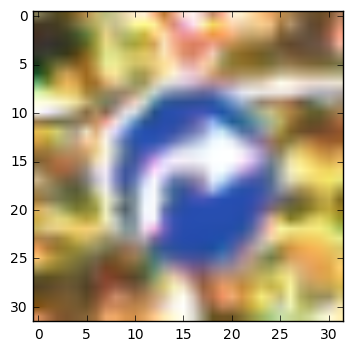

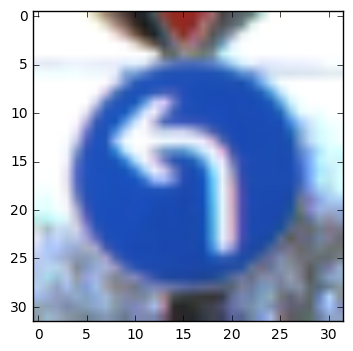

In [20]:
print_images(test_features[3])
print_images(test_features[32])

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.